# Preparation

In [1]:
import torch
import torchvision
import json
import os
import os.path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Any, Callable, Optional, Tuple
# from google.colab import files
from PIL import Image

In [2]:
# !gdown https://drive.google.com/uc?id=1B0TqxV0bsQrmZYF1IHdNZnbmth5HivoJ
# !tar -xf /content/noisy-train-set.tar

torch.cuda.is_available()

True

In [3]:
class DS801Dataset(torchvision.datasets.vision.VisionDataset):

    def __init__(
            self,
            data_path: str,
            transform: Optional[Callable] = None,
    ) -> None:

        # load data
        self.data_path = data_path
        # list of file names: File name must be this string format "label-filename"
        self.file_list = os.listdir(os.path.join(data_path, "imgs"))
        label_map_path = os.path.join(data_path, 'data-labels.json')
        self.label_map = json.load(open(label_map_path))


        self.transform = transform


    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """

        image_path = os.path.join(self.data_path, 'imgs', self.file_list[index])

        # load image
        img = Image.open(image_path).convert('RGB')
        # parsing label
        target = self.label_map[self.file_list[index].split('.')[0]]

        if self.transform is not None:
            img = self.transform(img)

        return index, img, torch.tensor(target)


    def __len__(self) -> int:
        return len(self.file_list)


# the function to transform image to tensors
def make_transforms():

    # we won't apply any data augmentation during the training pipeline, while you need to add augmented images into the datasets
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(size = 255),
        torchvision.transforms.CenterCrop(size = 240),
        # ToTensor applies standardization automatically when converting to Tensors.
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                         std = [0.229, 0.224, 0.225])
    ])


def build(data_path):
    return DS801Dataset(data_path=data_path, transform=make_transforms())

In [4]:
data_path = "/content/noisy-train-set"
data = DS801Dataset(data_path=data_path, transform=make_transforms())
print("# training images:", len(data))

# training images: 31848


In [5]:
_device = "cuda"
_batch_size = 48
_num_worders = 2
label_map = {
    0 : 'Cat',
    1 : 'Lynx',
    2 : 'Wolf',
    3 : 'Coyote',
    4 : 'Cheetah',
    5 : 'Jaguar',
    6 : 'Chimpanzee',
    7 : 'Orangutan',
    8 : 'Hamster',
    9 : 'Guinea Pig'
}
_num_classes = 10

In [6]:
train_data = build(data_path)
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=_batch_size,
                                           shuffle=False,
                                           drop_last=False,
                                           num_workers=_num_worders)

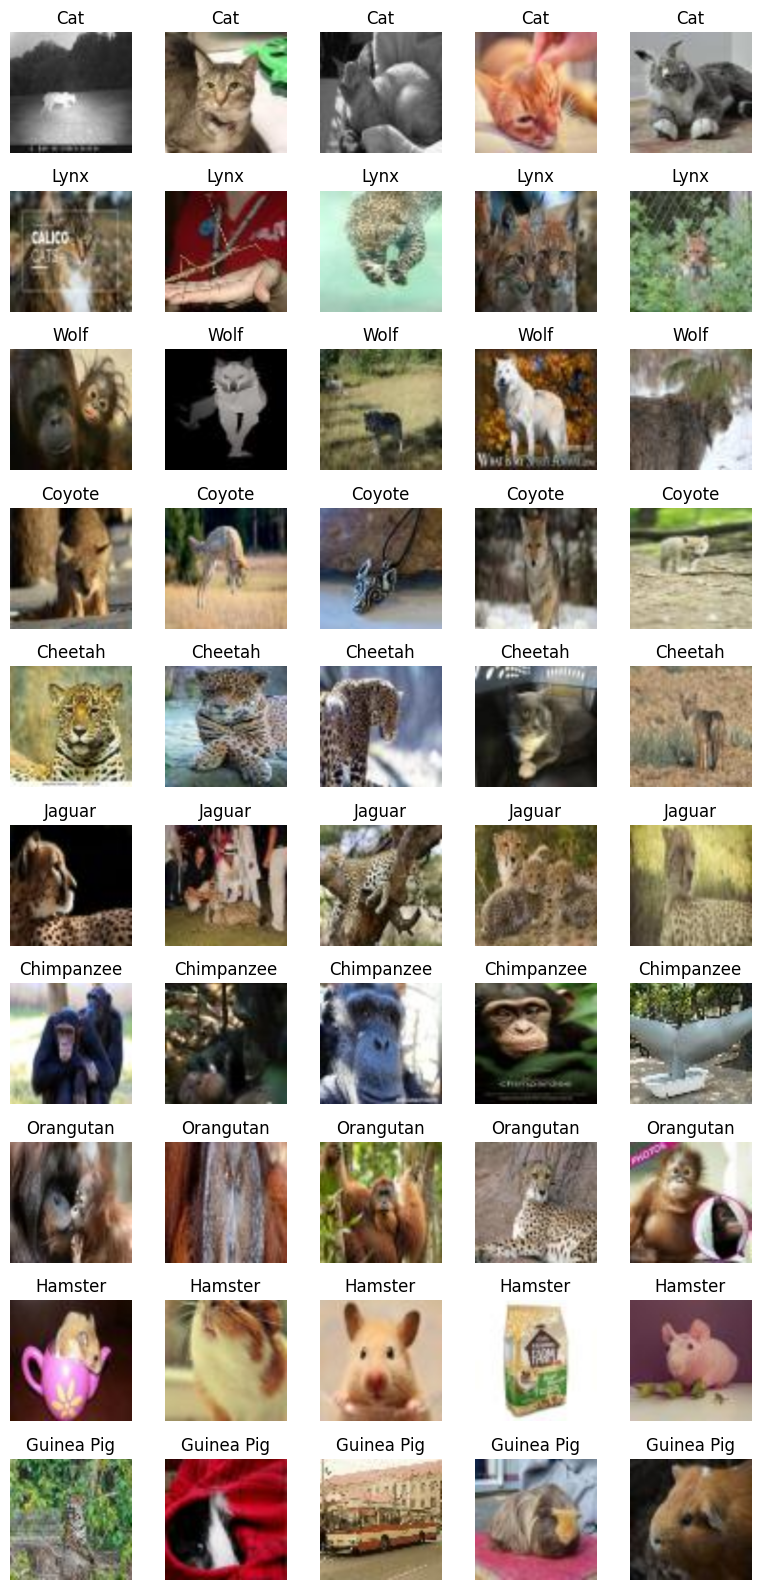

In [ ]:
examples = {i: [] for i in range(_num_classes)}
n_examples = 5
example_data = DS801Dataset(data_path=data_path,
                            transform=torchvision.transforms.Compose([
                                        torchvision.transforms.Resize(size = 255),
                                        torchvision.transforms.ToTensor()
                            ]))

for index, x, i in example_data:
    i = (i == 1).nonzero(as_tuple=True)[0].item()
    if all([len(ex) == n_examples for ex in examples.values()]):
        break
    if len(examples[i]) < n_examples:
        examples[i].append(x)

figure = plt.figure(figsize=(8, 16))
cols, rows = n_examples, _num_classes
label = 0
for i in range(1, cols * rows + 1):
    img = examples[label][i % cols]
    figure.add_subplot(rows, cols, i)
    plt.title(label_map[label])
    plt.axis("off")
    plt.tight_layout()
    plt.imshow(img.permute(1, 2, 0))
    if i % cols == 0:
        label += 1
plt.show()

#Outlier Handling

In [7]:
model = torchvision.models.efficientnet_b1(weights = "DEFAULT")
model = torch.nn.Sequential(*list(model.features.children()))   #  remove classifier layer to get the embedding
model.to(_device)
model.eval()

Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 69.5MB/s]


Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [8]:
embeddings = []
one_hot_labels = []
indices = []
for indxs, imgs, lbls in train_loader:
    imgs, lbls = imgs.to(_device), lbls.to(_device)
    outputs = model(imgs).squeeze(0, 2, 3)
    if len(embeddings) == 0:
        embeddings = outputs.detach().cpu().numpy()
        one_hot_labels = lbls.detach().cpu().numpy()
        indices = indxs.detach().cpu().numpy()
    else:
        embeddings = np.concatenate((embeddings, outputs.detach().cpu().numpy()))
        one_hot_labels = np.concatenate((one_hot_labels, lbls.detach().cpu().numpy()))
        indices = np.concatenate((indices, indxs.detach().cpu().numpy()))

class_labels = np.argmax(one_hot_labels, axis=1)

print("Dimensions of embeddings:", embeddings.shape)
print("Dimensions of labels:", class_labels.shape)
print("Dimensions of indices:", indices.shape)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Dimensions of embeddings: (31848, 1280, 8, 8)
Dimensions of labels: (31848,)
Dimensions of indices: (31848,)


In [9]:
embedding_averages = {i: [] for i in range(_num_classes)}

for i in range(_num_classes):
    indexes = np.where(class_labels == i)
    embedding_averages[i] = np.mean(embeddings[indexes], axis=0)

embedding_averages

{0: array([[[-0.12526664, -0.09682336, -0.09253225, ..., -0.0981503 ,
          -0.10966961,  1.8806592 ],
         [-0.10727413, -0.02635326, -0.05755496, ..., -0.05789284,
          -0.0077059 , -0.14004491],
         [-0.13370056, -0.09532379, -0.07348582, ..., -0.06977929,
          -0.10046998, -0.13428591],
         ...,
         [-0.1413628 , -0.09541688, -0.09552722, ..., -0.09405701,
          -0.08915646, -0.1479691 ],
         [-0.13829294, -0.08320993, -0.11033704, ..., -0.10105843,
          -0.07996433, -0.1451161 ],
         [-0.14115556, -0.14301713, -0.15722258, ..., -0.150011  ,
          -0.13902016, -0.15373221]],
 
        [[-0.1744042 , -0.17405637, -0.17112856, ..., -0.1605992 ,
          -0.16681676,  4.497484  ],
         [-0.1614241 , -0.0100243 ,  0.15250443, ...,  0.11813929,
          -0.02151068, -0.16838115],
         [-0.15279928,  0.08099665,  0.3552681 , ...,  0.29599842,
           0.03507151, -0.16328453],
         ...,
         [-0.17262278, -0.1019

In [14]:
torch.cuda.empty_cache()

In [15]:
embed_dataset = torch.utils.data.TensorDataset(torch.tensor(indices), torch.tensor(embeddings), torch.tensor(class_labels))
embed_loader = torch.utils.data.DataLoader(embed_dataset,
                                           batch_size=_batch_size,
                                           shuffle=False,
                                           drop_last=False,
                                           num_workers=_num_worders)

#Checking distance between each embedding against it's class average
dist_euclid = []
dist_cos = []
indexes = []
labels = []
for indxs, embds, lbls in embed_loader:
    for idx, emb, lbl in zip(indxs, embds, lbls):
        emb = emb.detach().cpu()
        lbl = lbl.item()
        avg = embedding_averages[lbl]
        lbl = [lbl]
        idx = [idx.item()]

        euc = [np.linalg.norm(emb - avg)]
        cos = [np.dot(emb.flatten(), avg.flatten()) / (np.linalg.norm(emb.flatten()) * np.linalg.norm(avg.flatten()))]

        if len(dist_euclid) == 0:
            dist_euclid = euc
            dist_cos = cos
            indexes = idx
            labels = lbl
        else:
            dist_euclid = np.concatenate((dist_euclid, euc))
            dist_cos = np.concatenate((dist_cos, cos))
            indexes = np.concatenate((indexes, idx))
            labels = np.concatenate((labels, lbl))

np.save('dist_euclid.npy', dist_euclid)
np.save('dist_cos.npy', dist_cos)
np.save('indexes.npy', indexes)
np.save('labels.npy', labels)

print("Dimension of euclidean distance:", dist_euclid.shape)
print("Dimension of cosine similarity:", dist_cos.shape)
print("Dimension of indices:", indexes.shape)
print("Dimension of labels:", labels.shape)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Dimension of euclidean distance: (31848,)
Dimension of cosine similarity: (31848,)
Dimension of indices: (31848,)
Dimension of labels: (31848,)


In [16]:
indexes

array([    0,     1,     2, ..., 31845, 31846, 31847])